In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os

import traj_sim
import utils
import models
import train_cSGM

import __main__

rng = np.random.default_rng()

This notebook is a demonstration of training a conditional SGM on data from a dynamical system described by multiscale SDEs. Consider the following system:
\
\
\begin{equation}
    \begin{split}
        \mbox{d} z_1(t) &= a_1\mbox{d} t + a_2\mbox{d} B_1 \\
        \mbox{d} z_2(t) &= -(-1 + 0.2z_1(t) + 4z_2(t)(-1 + z_2(t)^2))\mbox{d}t + a_3 \mbox{d} B_2(t)
    \end{split}
\end{equation}
\
For more details on the parameters of the SDEs and details behind this notebook and code, refer to https://arxiv.org/abs/2312.05715.

In [2]:
xs_0 = traj_sim.evolving_dwell(10000000)
#xs_0 = np.load('./evolving_dwell_xs.npy')

In [3]:
labels = xs_0[::, 0]
xs = torch.from_numpy(xs_0[::,:]).cpu()

In [4]:
step_rng = rng
cond_delta = 0.05
N_epochs = 5001
batch_size = 20
model_dir = './saved_models/Evolving_dwell/'

The above three cells first simulate a long trajectory of the system consisting of 10,000,000 sample points (or alternatively loading in a numpy file that has already been generated from a simulation). Then labeling the data based on the known slow coordinate, $z_1$. We can also label based on an identified diffusion map coordinate (see the related notebook for that demonstration). Then finally, we declare the parameters needed to train the SGM (i.e. the number of epochs, batch size, and cutoff for binning the conditional labels).  

In [5]:
score_model = train_cSGM.train(xs, labels, N_epochs, batch_size, cond_delta, model_dir)

Epoch 0 	, Loss 0.808662 
Epoch 500 	, Loss 0.313269 
Epoch 1000 	, Loss 0.476664 
Epoch 1500 	, Loss 0.267409 
Epoch 2000 	, Loss 0.284562 
Epoch 2500 	, Loss 0.867550 
Epoch 3000 	, Loss 0.353780 
Epoch 3500 	, Loss 0.400715 
Epoch 4000 	, Loss 0.324555 
Epoch 4500 	, Loss 0.201540 
Epoch 5000 	, Loss 0.200653 


In [6]:
setattr(__main__, "ScoreNet", models.ScoreNet)
score_model2 = torch.load('./saved_models/Evolving_dwell/global_step_005000.pth')


y = torch.full((500,), 5)
trained_score = lambda x, t: score_model2(x.float(), t.float(), y.int())
samples = utils.reverse_sde(step_rng, 2, 500, utils.drift, utils.diffusivity, trained_score)

Once we train the model, we can generate many points from the SGM conditioned on a label that we prescribe. Here $z_1 = 5$.

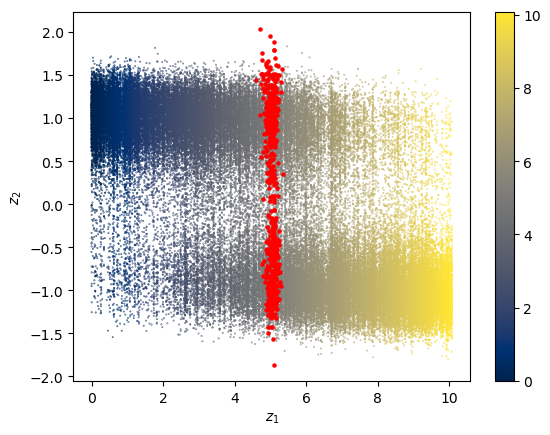

In [7]:
xs2 = xs_0[::100]
plt.scatter(xs2[:,0], xs2[:,1], c=labels[::100], s=0.1, cmap='cividis')
plt.colorbar()
plt.scatter(samples[:,0], samples[:,1], color='red', s = 5)
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.show()

Below, we compare the probability density function (PDF) of the generated 500 samples from the SGM with the ground truth PDF given by the equations. The generated samples are a reasonable approximation of the PDF, and we can now use these to initialize enhanced sampling simulations. 

In [8]:
x_bin = np.linspace(-2, 2, 25)

def potential(x):
    k=5
    return (x**2 - 1)**2 + (0.2*k - 1)*x

def true_pdf(x):
    exp_minus_potential_x = np.exp(-potential(x))
    return exp_minus_potential_x / np.trapz(exp_minus_potential_x, x=x)

In [9]:
est_pdf, est_bins = np.histogram(np.hstack(samples[:,1]), bins=x_bin, density=True)
dbin = est_bins[1] - est_bins[0]
x = (est_bins + dbin / 2)[:-1]
l1_norm = np.trapz(np.abs(est_pdf - true_pdf(x)), x=x)

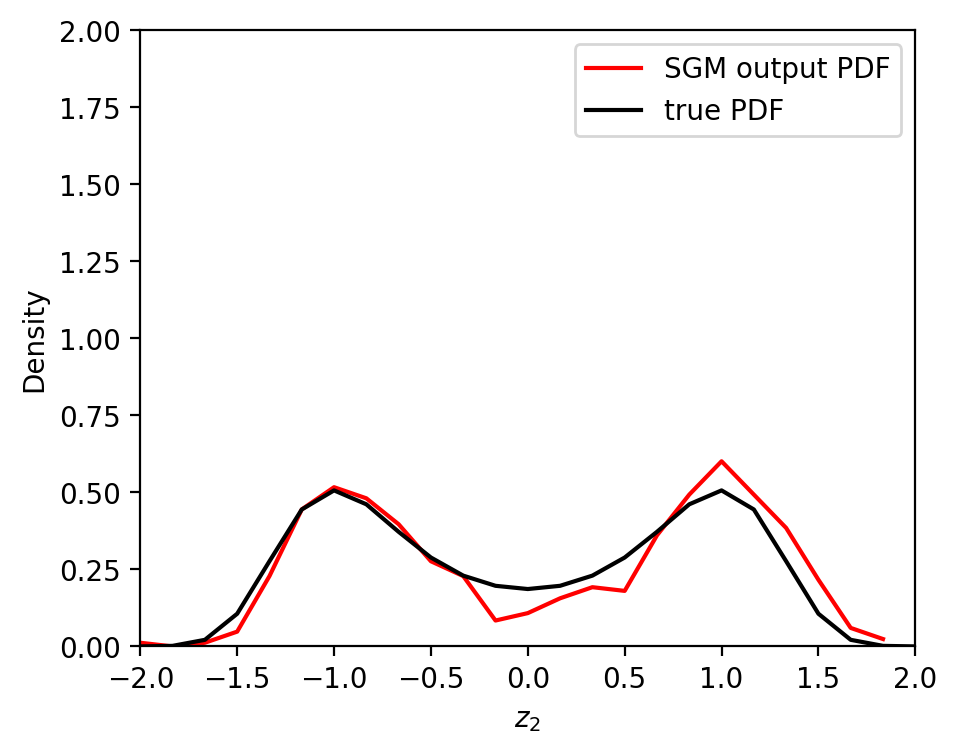

In [10]:
plt.figure(figsize = (5,4), dpi=200)
plt.plot(est_bins[:24], est_pdf, label='SGM output PDF', color='red')#, density=True)
plt.plot(x_bin, true_pdf(x_bin), label='true PDF', color='k')
plt.xlim(-2, 2)
plt.ylim(0, 2)
plt.ylabel(r"Density")
plt.xlabel(r"$z_2$")
plt.legend(loc='upper right')